In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pyrocko import gf
from pyrocko.gf import LocalEngine
from pyrocko import moment_tensor as mtm
from scipy.signal import spectrogram, istft


# Synthetic seismograms using power law noise distribution

## Intro
This notebook shows how to use the Pyrocko-gf Python library to generate synthetic seismograms with a custom source time function consisting of point sources distributed in amplitude according to a power law. 

Pyrocko-gf is a library (part of the Pyrocko seismic processing library) that allows construction of synthetic seismogram from specified source functions and Green's functions.  The library comes with several defined sources (including point sources and finite sources) and source-time functions. Custom sources and source time functions can be created as classes.  Green's functions can be created from scratch or downloaded with the `fomosto` package, included with Pyrocko. 

A more comprehensive introduction to the package is at

https://pyrocko.org/docs/current/topics/pyrocko-gf.html

The process for computing synthetic seismograms consists of the following.

1. Load the Green's functions for the medium in which you are calculating the synthetic. Pyrocko expects a particular format that stores multiple precomputed Green's functions on a source-receiver grid. 

2. Create a 'Source' object.  The source object contains information on, well, the seismic source characteristics. Users can specify
    - The source time function
    - The source mechanism, in terms of a standard mechanism or an arbitrary moment tensor.  Point sources and finite sources are possible.
    - The location, depth, and size/magnitude
    
3. Create a 'Target' object.  This is essentyially the seismic receiver. For this you specify 
    - location, depth
    - measured component(s)
    - time range (indexed to the time of the event) for which you want the synthetic computed

Pyrocko-gf can then calculate the syntheic seismogram.

## Example

Start by loading a precomputed Green's function from https://greens-mill.pyrocko.org

Numerous precomputed Green's functions exist on that page.  

In [2]:
model = 'synthseismograms/crust2_m5_hardtop_16Hz'

engine = LocalEngine(store_dirs=[model])

Pyrocko-gf comes with several theoretical source-time functions. Examples indclude triangular, decaying sinusoid ("resonator"), and trapezoidal ("boxcar").



Text(0.5, 1.0, 'Boxcar Source Time Function')

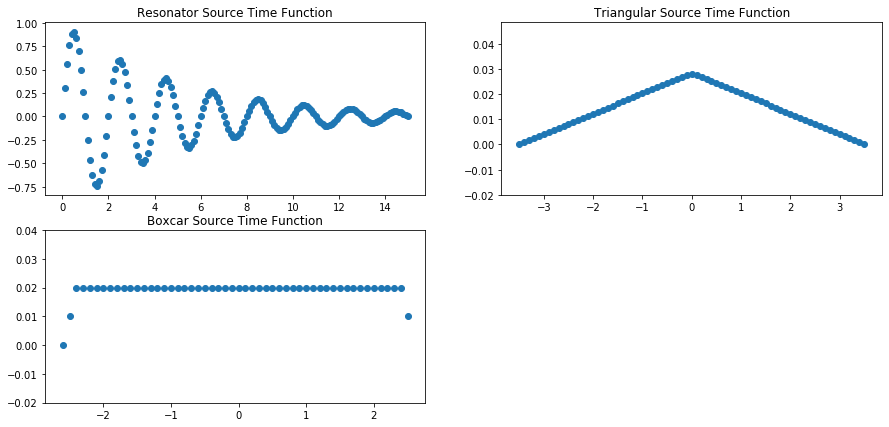

In [3]:
duration=5

stf_tri = gf.TriangularSTF(duration, peak_ratio=0.5, anchor=0.)
stf_res = stf = gf.ResonatorSTF(duration, frequency=.5)
stf_boxcar = stf = gf.BoxcarSTF(duration, anchor=0.)

plt.figure(figsize=(15,7))

(x,y) = stf_tri.discretize_t(0.1,0)
plt.subplot(222)
_=plt.scatter(x,y)
plt.title("Triangular Source Time Function")

(x,y) = stf_res.discretize_t(0.1,0)
plt.subplot(221)
_=plt.scatter(x,y)
plt.title("Resonator Source Time Function")

(x,y) = stf_boxcar.discretize_t(0.1,0)
plt.subplot(223)
_=plt.scatter(x,y)
plt.title("Boxcar Source Time Function")

Next, we will create several sources, including an explosion source, double couple, moment tensor (with same parameters as the double couple), rectangular finite fault, and a ring fault.

In [4]:
#Parameters

# Change this to change the source time function
stf = stf_boxcar
mag = 2
# stick slip fault
dip = 90
strike = 0
rake = 0
mt = mtm.MomentTensor(strike=strike, 
                      dip=dip, 
                      rake=rake, 
                      scalar_moment=mtm.magnitude_to_moment(mag))
#Earthquake location
lat = 0
long = 0
depth = 2e3

# Sources 
exp_source = gf.ExplosionSource(lat=lat, lon=long, depth=depth, volume_change=5e8)

dc_source = gf.DCSource(stf=stf, lat=lat, lon=long, depth=depth, strike=strike, dip=dip, rake=rake)

mt_source = gf.MTSource(stf=stf,
   lat=lat, lon=long, depth=depth,
   mnn=mt.mnn, mee=mt.mee, mdd=mt.mdd,
   mne=mt.mne, mnd=mt.mnd, med=mt.med)

rect_source = gf.RectangularSource(stf=stf,
    lat=lat, lon=long, depth=depth,
    dip=dip, strike=strike, rake=rake, #lateral strike-slip
    width=1e3, length=2e3, slip=1)

ring_source = gf.RingfaultSource(stf=stf,
    lat=lat, lon=long, depth=depth,
    dip=dip, diameter=1e1, sign=-1)

Then, a single target seismometer is created.

In [5]:
target = gf.Target(
       quantity='displacement',
       lat=0, lon=1,
       store_id=model,
       codes=('NET', 'STA', 'LOC', 'E'),
       tmin=15, tmax=50)

## Results
The following show synthetic seismograms and calculated spectrograms for each source.

In [6]:
response = engine.process(exp_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Explosion Source, source-time={}'.format(type(stf)))

StoreError: directory "/Users/nate/Dropbox/SyntheticSignals/synthseismograms/synthseismograms/crust2_m5_hardtop_16Hz" does not seem to contain a GF store ("config" file not found)

In [9]:
response = engine.process(rect_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Rectangle Source, source-time={}'.format(type(stf)))

NoSuchStore: no GF store with id "synthseismograms/crust2_m5_hardtop_16Hz" found. Searched folders:
  /Users/nate/Dropbox/SyntheticSignals/synthseismograms/crust2_m5_hardtop_16Hz

In [ ]:
response = engine.process(mt_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.2, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Moment Tensor Source, source-time={}'.format(type(stf)))

In [ ]:
response = engine.process(dc_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Double Couple Source, source-time={}'.format(type(stf)))

In [ ]:
response = engine.process(ring_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Ring Fault Source, source-time={}'.format(type(stf)))

# Create a new source time function class.
Below we create a new source time function using random asperities, the amplitudes of which follow a power law distribution. 

Pyrocko source-time functions subclass the `STF` class.  See the following for another example:

https://pyrocko.org/docs/current/library/examples/gf_forward.html#creating-a-custom-source-time-function-stf

In [ ]:
from pyrocko.gf import STF
from pyrocko.guts import Float, Int

class PowerLawSTF(STF):
    '''Poisson distributed random impulses based on a power law.'''
        

    duration = Float.T(
        default=0.0,
        help='baseline of the ramp')

    anchor = Float.T(
        default=0.0,
        help='anchor point with respect to source-time: ('
             '-1.0: left -> source duration [0, T] ~ hypocenter time, '
             ' 0.0: center -> source duration [-T/2, T/2] ~ centroid time, '
             '+1.0: right -> source duration [-T, 0] ~ rupture end time)')
    
    mag = Float.T(
        default=5.0,
        help='magnitude')
    
    b = Float.T(
        default=1.2,
        help='b parameter for power law')
    
    poisson_envelope = Int.T(
        default = 0,
        help='Whether to apply a Poisson distribution envelope to the magnitudes of the asperities.')
    
    mu = Float.T(
        default = 10,
        help = 'Mu parameter for Poisson envelope')
    
    loc = Float.T(
        optional = True,
        help = "'loc' parameter for Poisson distribution function")
    

    def discretize_t(self, deltat, tref):
        
        # Power law - based on Gutenberg-Richter
        M = np.linspace(0,self.mag,1000)
        pdf = self.b*np.log(10)*10**(-self.b*M)
        self.cdf = 1-10**(-self.b*M)

        # method returns discrete times and the respective amplitudes
        tmin_stf = tref - self.duration * (self.anchor + 1.) * 0.5
        tmax_stf = tref + self.duration * (1. - self.anchor) * 0.5
        tmin = round(tmin_stf / deltat) * deltat
        tmax = round(tmax_stf / deltat) * deltat
        nt = int(round((tmax - tmin) / deltat)) + 1
        times = np.linspace(tmin, tmax, nt)
        if nt > 1:
            self._amplitudes = np.random.uniform(min(self.cdf),max(self.cdf),nt)  
            if self.poisson_envelope:
                x = np.linspace(0,nt-1,nt)
                self.envelope = stats.poisson.pmf(x, mu=self.mu, loc=self.loc)
                self.amplitudes = self.mag*(self._amplitudes * self.envelope)
            else:
                self.amplitudes = self._amplitudes
        else:
            self.amplitudes = np.ones(1)

        return times, self.amplitudes

    def base_key(self):
        # method returns STF name and the values
        return (self.__class__.__name__, self.duration, self.anchor)

### Create a source time function with the above class.

An example of plot of the generated function is below.

In [ ]:
stf_gr = PowerLawSTF(duration=10,anchor=0,mag=10,b=1.2)

In [ ]:
(x,y) = stf_gr.discretize_t(0.1,0)
_=plt.scatter(x,y)
plt.title("Power law source time function")

### Here is an example synthetic seismogram and spectrogram using a double couple source and power law source time function

In [ ]:
response = engine.process(dc_source, [target])
synthetic_trace = response.pyrocko_traces()[0]
synthetic_trace.plot()

df = len(synthetic_trace.get_xdata())

f, t, Sxx = spectrogram(synthetic_trace.get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('Double Couple Source')

## Create multiple quakes with power law random source mechanics

In [ ]:
n_quakes = 10
mag = 3
duration=10
mu = duration * 100
loc = -(mu - duration)

stf_gr = PowerLawSTF(duration=duration,anchor=0,mag=10,b=1.2, poisson_envelope=1, mu=mu, loc = loc)

stfs = [PowerLawSTF(duration=duration,anchor=0,mag=mag,b=1.2) for x in range(n_quakes)]

In [ ]:
'''target = gf.Target(
       quantity='displacement',
       lat=0, lon=2,
       store_id=model,
       codes=('NET', 'STA', 'LOC', 'E'),
       tmin=10, tmax=100)

# Normal fault
dip = 90
strike = 0
rake = -90

lat = 0
long = 0
depth = 2e3'''

rect_sources = [gf.RectangularSource(stf=source_time_function,
                                     magnitude=mag,
                         lat=lat, lon=long, depth=depth,
                         dip=dip, strike=strike, rake=rake, 
                         width=1e3, length=2e3, slip=1)
           for source_time_function in stfs]

dc_sources = [gf.DCSource(stf=source_time_function, magnitude=mag,
                          lat=lat, lon=long, depth=depth, strike=strike, dip=dip, rake=rake)
              for source_time_function in stfs]      

ring_sources = [gf.RingfaultSource(stf=source_time_function, magnitude=mag,
                         #stf_mode='pre',
                         lat=lat, lon=long, depth=depth,
                         dip=dip, diameter=2e3, sign=-1)
           for source_time_function in stfs]


In [ ]:
sources = dc_sources

'''(x,y) = stfs[2].discretize_t(deltat=.1,tref=0)
plt.scatter(x,y)'''

quakes = [engine.process(source, [target]).pyrocko_traces()[0] for source in sources]

## Example seismogram with power law source time function

In [ ]:
i = 2

quakes[i].plot()

df = len(quakes[i].get_xdata())

f, t, Sxx = spectrogram(quakes[i].get_ydata(),0.02, nperseg=int(df/10), noverlap=int(df/11), scaling='density')

plt.pcolormesh(np.log(Sxx))
_ = plt.title('GR Law Source')

### Difference between two of the seismograms

In [ ]:
plt.plot(quakes[0].ydata-quakes[1].ydata)

